In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(
    os.path.join(processed_data_folder, "stores-sales.parquet")
)[["Store", "StoreType", "StateHoliday", "Promo", "Sales"]]

stores_sales_df["StateHoliday"] = stores_sales_df["StateHoliday"].map(
    {"0": 0, "a": 1, "b": 2, "c": 3}
)

stores_sales_df["StoreType"] = stores_sales_df["StoreType"].map(
    {"a": 0, "b": 1, "c": 2, "d": 3}
)

stores_sales_df

,Store,StoreType,StateHoliday,Promo,Sales
Date,,,,,
2013-01-01,1115,3,1,0,0
2013-01-01,746,3,1,0,0
2013-01-01,171,0,1,0,0
2013-01-01,694,0,1,0,0
2013-01-01,396,0,1,0,0
...,...,...,...,...,...
2015-07-31,612,3,0,1,8161
2015-07-31,235,0,0,1,6756
2015-07-31,1078,3,0,1,9732


In [4]:
weekly_stores_sales_df = stores_sales_df.groupby("Store").resample("W").agg({
    "Sales": "sum",
    "StateHoliday": "max",
    "Promo": "max",
    "StoreType": "max"
}).reset_index()

weekly_stores_sales_df

,Store,Date,Sales,StateHoliday,Promo,StoreType
0,1,2013-01-06,19340,1.0,0.0,2.0
1,1,2013-01-13,32952,0.0,1.0,2.0
2,1,2013-01-20,25978,0.0,0.0,2.0
3,1,2013-01-27,33071,0.0,1.0,2.0
4,1,2013-02-03,28693,0.0,0.0,2.0
...,...,...,...,...,...,...
150520,1115,2015-07-05,48130,0.0,1.0,3.0
150521,1115,2015-07-12,36233,0.0,0.0,3.0
150522,1115,2015-07-19,45927,0.0,1.0,3.0
150523,1115,2015-07-26,35362,0.0,0.0,3.0


In [5]:
validation_weekly_stores_sales_df = weekly_stores_sales_df[weekly_stores_sales_df.Date > "2015-02"]
weekly_stores_sales_df = weekly_stores_sales_df[weekly_stores_sales_df.Date < "2015-02"]

In [6]:
sales_transform = StandardScaler()

weekly_stores_sales_df["Sales"] = sales_transform.fit_transform(weekly_stores_sales_df[["Sales"]]).squeeze()
weekly_stores_sales_df = pd.get_dummies(weekly_stores_sales_df, columns=["StateHoliday"])

In [7]:
weekly_stores_sales_df["Year"] = weekly_stores_sales_df["Date"].dt.year
weekly_stores_sales_df["Month"] = weekly_stores_sales_df["Date"].dt.month
weekly_stores_sales_df["WeekOfYear"] = weekly_stores_sales_df["Date"].dt.isocalendar().week

In [8]:
weekly_stores_sales_df["Sales_Lag1"] = weekly_stores_sales_df.groupby("Store")["Sales"].shift(1)
weekly_stores_sales_df["Sales_Lag2"] = weekly_stores_sales_df.groupby("Store")["Sales"].shift(2)

weekly_stores_sales_df["Sales_2Week_Avg"] = (
    weekly_stores_sales_df
        .groupby("Store")["Sales"]
        .rolling(window=2)
        .mean()
        .shift(1)
        .reset_index(drop=True)
)

weekly_stores_sales_df = weekly_stores_sales_df.dropna()
weekly_stores_sales_df

,Store,Date,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
2,1,2013-01-20,-0.688314,0.0,2.0,True,False,False,False,2013,1,3,-0.303893,-1.054214,-0.679053
3,1,2013-01-27,-0.297333,1.0,2.0,True,False,False,False,2013,1,4,-0.688314,-0.303893,-0.496103
4,1,2013-02-03,-0.538658,0.0,2.0,True,False,False,False,2013,2,5,-0.297333,-0.688314,-0.492824
5,1,2013-02-10,-0.148504,1.0,2.0,True,False,False,False,2013,2,6,-0.538658,-0.297333,-0.417996
6,1,2013-02-17,-0.583472,0.0,2.0,True,False,False,False,2013,2,7,-0.148504,-0.538658,-0.343581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120388,892,2014-12-28,0.045966,0.0,0.0,False,False,False,True,2014,12,52,2.205702,0.377691,-0.120309
120389,892,2015-01-04,-0.395451,0.0,0.0,False,True,False,False,2015,1,1,0.045966,2.205702,-0.199712
120390,892,2015-01-11,0.642662,1.0,0.0,True,False,False,False,2015,1,2,-0.395451,0.045966,-0.130975
120391,892,2015-01-18,0.510314,1.0,0.0,True,False,False,False,2015,1,3,0.642662,-0.395451,-0.011416


In [9]:
suffled_weekly_stores_sales_df = weekly_stores_sales_df.copy()

suffled_weekly_stores_sales_df["rnd_index"] = np.random.default_rng(seed=42).permutation(
    len(suffled_weekly_stores_sales_df)
)

suffled_weekly_stores_sales_df = (
    suffled_weekly_stores_sales_df
        .set_index("rnd_index")
        .sort_index()
        .drop("Date", axis="columns")
)

suffled_weekly_stores_sales_df

,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,,
0,838,0.584564,1.0,3.0,False,True,False,False,2014,5,18,-0.315248,0.880183,-0.685337
1,572,-0.443682,0.0,3.0,True,False,False,False,2014,3,11,0.556782,-0.321753,-0.076487
2,237,-0.517381,1.0,0.0,True,False,False,False,2014,7,27,-0.787864,-0.577023,0.021906
3,349,0.095080,0.0,2.0,True,False,False,False,2014,1,3,0.573760,-0.063065,-0.237168
4,721,-0.056340,0.0,0.0,True,False,False,False,2014,6,26,0.408449,-0.182294,0.044092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90264,736,-0.822426,0.0,2.0,True,False,False,False,2014,2,7,-0.042063,-0.752145,-0.230608
90265,801,-0.283443,1.0,3.0,True,False,False,False,2014,11,45,-0.773202,-0.565061,-0.450132
90266,198,-1.562549,0.0,0.0,False,True,False,False,2014,11,44,-1.034866,-1.522696,0.662975


In [10]:
data_len = len(suffled_weekly_stores_sales_df.index)
test_len = int(data_len * 0.2)

train_df = suffled_weekly_stores_sales_df.iloc[:-test_len]
test_df = suffled_weekly_stores_sales_df.iloc[-test_len:]

display(train_df)
display(test_df)

,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,,
0,838,0.584564,1.0,3.0,False,True,False,False,2014,5,18,-0.315248,0.880183,-0.685337
1,572,-0.443682,0.0,3.0,True,False,False,False,2014,3,11,0.556782,-0.321753,-0.076487
2,237,-0.517381,1.0,0.0,True,False,False,False,2014,7,27,-0.787864,-0.577023,0.021906
3,349,0.095080,0.0,2.0,True,False,False,False,2014,1,3,0.573760,-0.063065,-0.237168
4,721,-0.056340,0.0,0.0,True,False,False,False,2014,6,26,0.408449,-0.182294,0.044092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72211,594,-0.825292,1.0,0.0,True,False,False,False,2013,3,12,-1.075105,-0.694157,0.351563
72212,148,0.781515,1.0,0.0,True,False,False,False,2014,3,12,0.259619,1.068535,0.039958
72213,436,0.213372,1.0,3.0,True,False,False,False,2014,2,6,-0.493072,-0.121384,1.255233


,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,,
72216,166,-0.480008,0.0,0.0,True,False,False,False,2014,1,3,0.166959,-0.266796,1.386479
72217,840,0.259564,1.0,0.0,False,True,False,False,2014,5,18,-0.440485,0.157974,0.244075
72218,591,-0.608442,0.0,0.0,False,False,False,True,2013,12,52,0.629819,-0.270213,0.268218
72219,136,-0.443572,1.0,0.0,False,True,False,False,2013,8,33,-0.809803,-0.011416,-0.564730
72220,128,-0.257480,0.0,3.0,False,True,False,False,2014,6,24,0.837904,-0.111076,-0.119344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90264,736,-0.822426,0.0,2.0,True,False,False,False,2014,2,7,-0.042063,-0.752145,-0.230608
90265,801,-0.283443,1.0,3.0,True,False,False,False,2014,11,45,-0.773202,-0.565061,-0.450132
90266,198,-1.562549,0.0,0.0,False,True,False,False,2014,11,44,-1.034866,-1.522696,0.662975


In [11]:
X_train, y_train = train_df.drop("Sales", axis="columns"), train_df[["Sales"]]
X_test, y_test = test_df.drop("Sales", axis="columns"), test_df[["Sales"]]

In [12]:
xgbr_regressor = XGBRegressor()

In [13]:
xgbr_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
train_predictions = pd.DataFrame()
train_predictions["True Sales"] = (
    sales_transform
        .inverse_transform(train_df[["Sales"]])
        .squeeze()
)
train_predictions["Predicted Sales"] = (
    sales_transform
        .inverse_transform((xgbr_regressor.predict(X_train))[np.newaxis, :])
        .squeeze()
)

test_predictions = pd.DataFrame()
test_predictions["True Sales"] = (
    sales_transform
        .inverse_transform(test_df[["Sales"]])
        .squeeze()
)
test_predictions["Predicted Sales"] = (
    sales_transform
        .inverse_transform(xgbr_regressor.predict(X_test)[np.newaxis, :])
        .squeeze()
)

display(train_predictions)
display(test_predictions)

,True Sales,Predicted Sales
0,49070.0,52667.875000
1,30416.0,31957.423828
2,29079.0,28624.570312
3,40190.0,36753.703125
4,37443.0,37025.226562
...,...,...
72211,23493.0,24618.210938
72212,52643.0,54322.878906
72213,42336.0,38891.875000
72214,45140.0,48473.445312


,True Sales,Predicted Sales
0,29757.0,34239.414062
1,43174.0,41368.296875
2,27427.0,23047.617188
3,30418.0,29912.310547
4,33794.0,33973.402344
...,...,...
18048,23545.0,24774.296875
18049,33323.0,34102.464844
18050,10118.0,9615.100586
18051,43495.0,47316.644531


In [15]:
train_mae = mean_absolute_error(
    train_predictions["True Sales"],
    train_predictions["Predicted Sales"]
)
train_mse = mean_squared_error(
    train_predictions["True Sales"],
    train_predictions["Predicted Sales"]
)

test_mae = mean_absolute_error(
    test_predictions["True Sales"],
    test_predictions["Predicted Sales"]
)
test_mse = mean_squared_error(
    test_predictions["True Sales"],
    test_predictions["Predicted Sales"]
)

results_df = pd.DataFrame(
    data=[
        {"MAE": train_mae, "MSE": train_mse},
        {"MAE": test_mae, "MSE": test_mse},
    ],
    index=["Train", "Test"]
)

print(f"Forecasting results:")
display(results_df)

Forecasting results:


,MAE,MSE
Train,2043.832137,9.412104e+06
Test,2368.342721,1.566004e+07


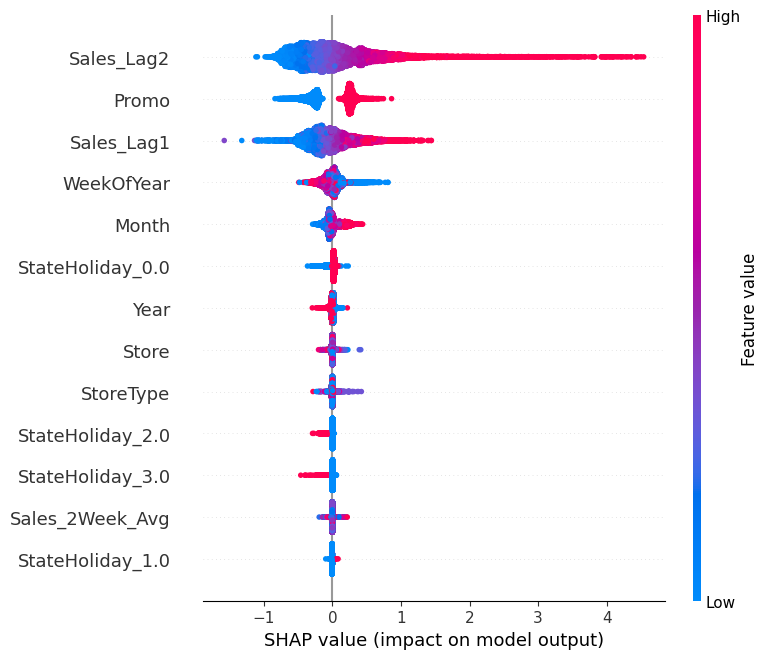

In [16]:
explainer = shap.Explainer(xgbr_regressor)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

In [17]:
X_train

,Store,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,
0,838,1.0,3.0,False,True,False,False,2014,5,18,-0.315248,0.880183,-0.685337
1,572,0.0,3.0,True,False,False,False,2014,3,11,0.556782,-0.321753,-0.076487
2,237,1.0,0.0,True,False,False,False,2014,7,27,-0.787864,-0.577023,0.021906
3,349,0.0,2.0,True,False,False,False,2014,1,3,0.573760,-0.063065,-0.237168
4,721,0.0,0.0,True,False,False,False,2014,6,26,0.408449,-0.182294,0.044092
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72211,594,1.0,0.0,True,False,False,False,2013,3,12,-1.075105,-0.694157,0.351563
72212,148,1.0,0.0,True,False,False,False,2014,3,12,0.259619,1.068535,0.039958
72213,436,1.0,3.0,True,False,False,False,2014,2,6,-0.493072,-0.121384,1.255233


In [18]:
validation_weekly_stores_sales_df

,Store,Date,Sales,StateHoliday,Promo,StoreType
109,1,2015-02-08,29690,0.0,1.0,2.0
110,1,2015-02-15,24477,0.0,0.0,2.0
111,1,2015-02-22,26902,0.0,1.0,2.0
112,1,2015-03-01,25566,0.0,0.0,2.0
113,1,2015-03-08,31369,0.0,1.0,2.0
...,...,...,...,...,...,...
150520,1115,2015-07-05,48130,0.0,1.0,3.0
150521,1115,2015-07-12,36233,0.0,0.0,3.0
150522,1115,2015-07-19,45927,0.0,1.0,3.0
150523,1115,2015-07-26,35362,0.0,0.0,3.0


In [19]:
def extract_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Year"] = df_copy.index.year
    df_copy["Month"] = df_copy.index.month
    df_copy["WeekOfYear"] = df_copy.index.isocalendar().week
    return df_copy

In [20]:
def extract_dummy_features(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = pd.get_dummies(df, columns=["StateHoliday"])
    for i in range(4):
        feature_name = f"StateHoliday_{i}.0"
        if feature_name not in df_copy.columns:
            df_copy[feature_name] = False
    return df_copy

In [21]:
def extract_historic_features(df: pd.Series, history_df: pd.DataFrame, window: int = 2) -> pd.Series:
    df_copy = df.copy()
    lags = history_df.Sales.values[-2:]
    df_copy["Sales_Lag1"] = lags[1]
    df_copy["Sales_Lag2"] = lags[0]
    df_copy["Sales_2Week_Avg"] = lags.mean()
    return df_copy

In [22]:
def get_forecast(extra_features_df: pd.DataFrame, history_df: pd.DataFrame, model: xgboost.XGBModel) -> pd.DataFrame:
    extended_features_df = extract_time_features(extract_dummy_features(extra_features_df))
    
    results_df = pd.DataFrame(index=extended_features_df.index)
    
    predictions_list = []
    for i in range(len(extended_features_df)):
        features = extract_historic_features(extended_features_df.iloc[i, :], history_df)
        prediction = model.predict(features.values[np.newaxis, :])[0]
        predictions_list.append(prediction)
        features["Sales"] = prediction
        history_df = pd.concat([history_df, features.to_frame().T.convert_dtypes()])

    results_df["Predictions"] = sales_transform.inverse_transform([predictions_list]).squeeze()
    return results_df

In [23]:
(
    stores_sales_df.loc["2013-01-01"][["StoreType", "Store"]]
        .sort_values("Store")
        .groupby("StoreType")
        .head(5)
        .sort_values(["StoreType", "Store"])
)

,StoreType,Store
Date,,
2013-01-01,0,2
2013-01-01,0,3
2013-01-01,0,5
2013-01-01,0,6
2013-01-01,0,7
2013-01-01,1,85
2013-01-01,1,259
2013-01-01,1,262
2013-01-01,1,274


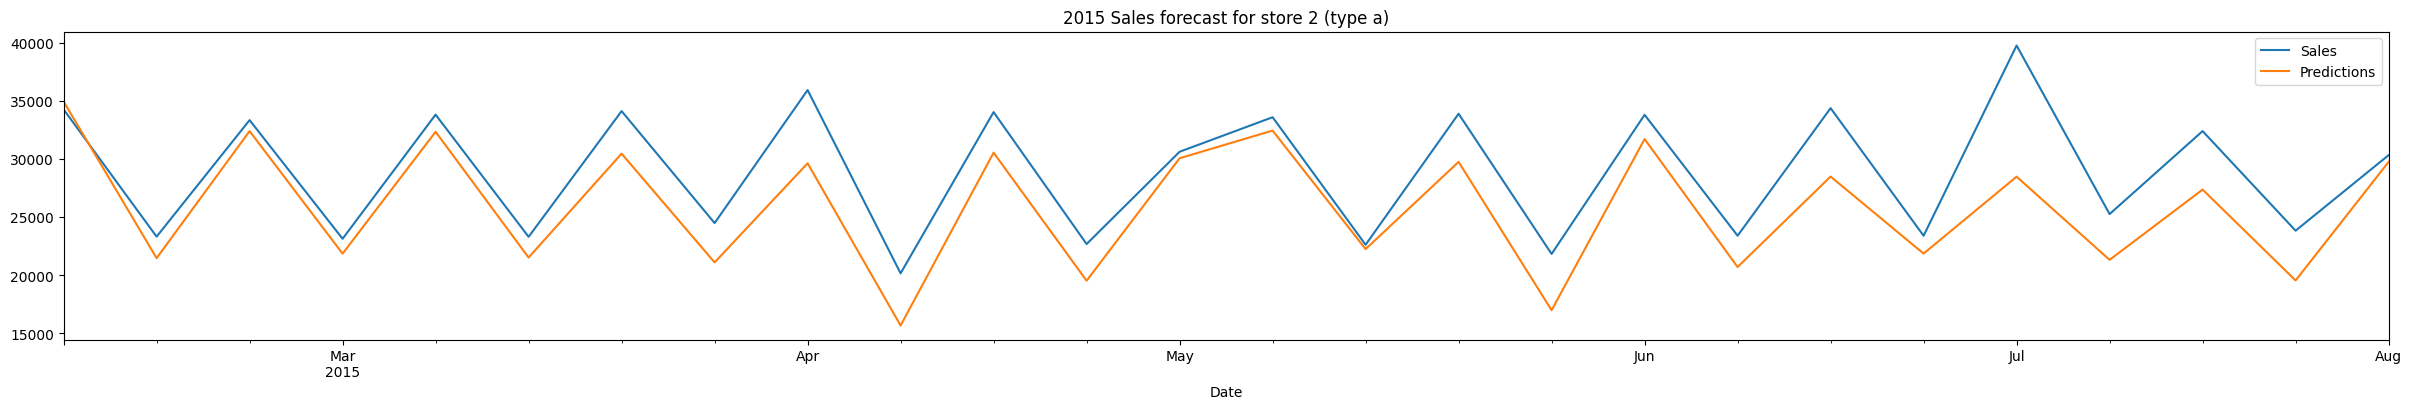

MAE: 3108.2784444771164 -- MSE: 15226727.402914645


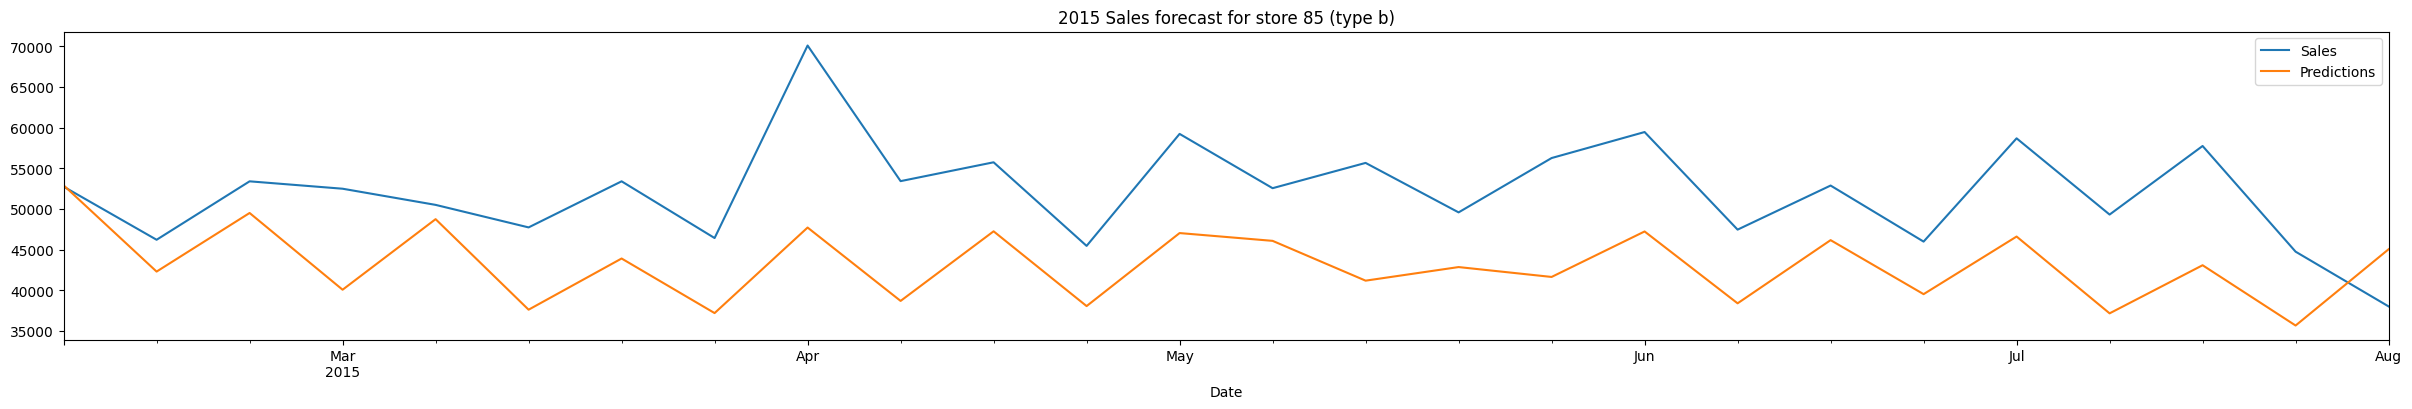

MAE: 9530.832982875592 -- MSE: 112503203.70018172


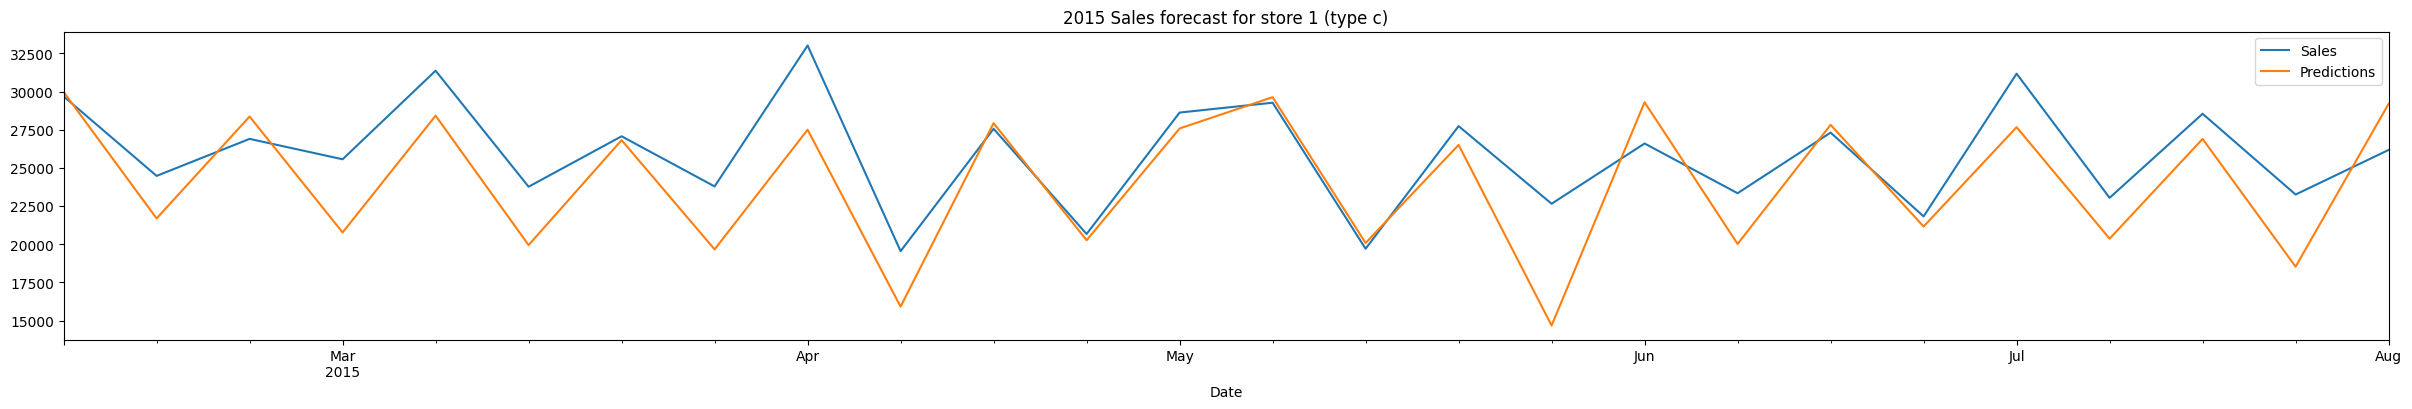

MAE: 2468.2953565297234 -- MSE: 9866292.38697738


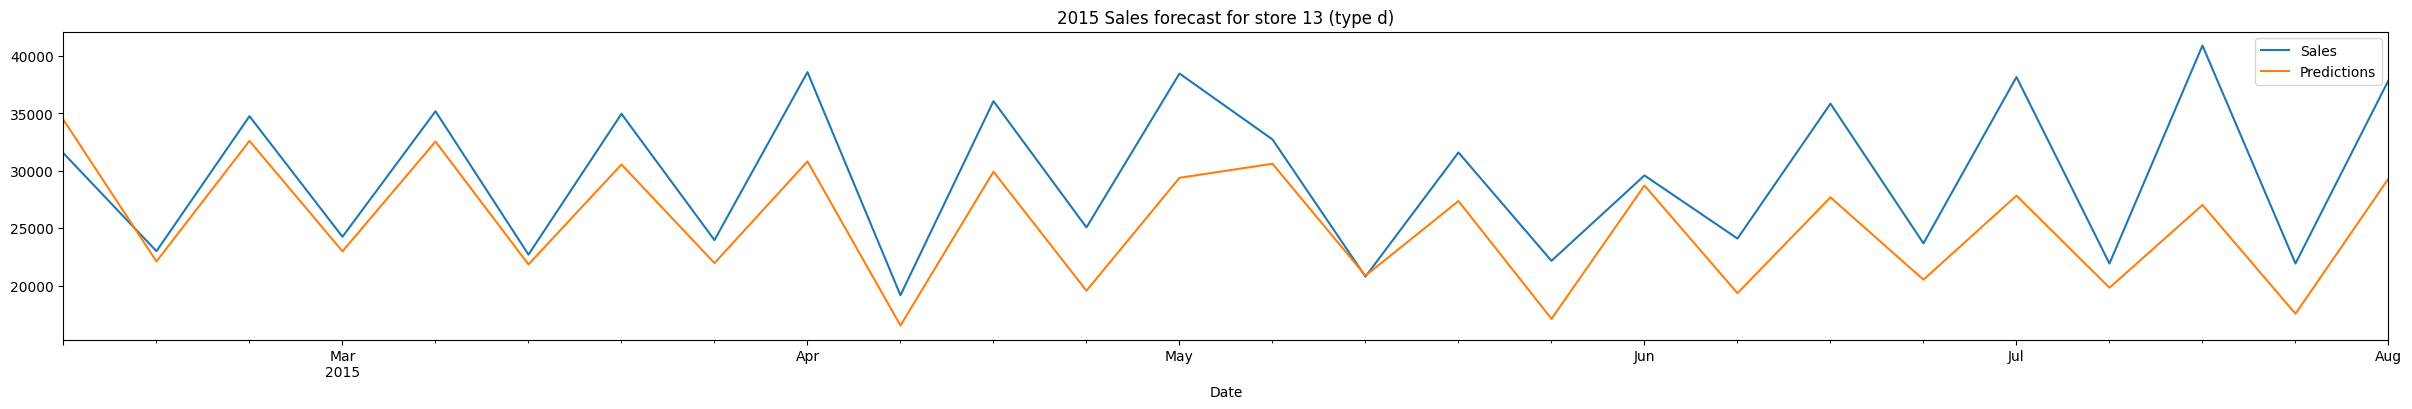

MAE: 4459.251724543535 -- MSE: 31090500.006059118


In [24]:
selected_stores = {
    "a": 2,
    "b": 85,
    "c": 1,
    "d": 13
}

for store_type, store_id in selected_stores.items():
    history_df = weekly_stores_sales_df[weekly_stores_sales_df.Store == store_id].set_index("Date")
    
    validation_sample = (
        validation_weekly_stores_sales_df[validation_weekly_stores_sales_df.Store == store_id].set_index("Date")
    )
    validation_trues = validation_sample.pop("Sales")
    
    results_df = get_forecast(validation_sample, history_df, xgbr_regressor)
    results_df["Sales"] = validation_trues
    
    mae = mean_absolute_error(results_df["Sales"], results_df["Predictions"])
    mse = mean_squared_error(results_df["Sales"], results_df["Predictions"])
    
    plt.figure()
    plt.title(f"2015 Sales forecast for store {store_id} (type {store_type})");

    ax = results_df["Sales"].plot(kind="line", figsize=(30, 4))
    results_df["Predictions"].plot(kind="line", ax=ax)
    ax.legend();
    plt.show()
    
    print(f"MAE: {mae} -- MSE: {mse}")